In [61]:
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [62]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")


**Data Cleaning**

In [63]:
#Calculating missing value count in each attribute.
missing = train.isnull().sum().sort_values(ascending = False)
missing.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

<AxesSubplot:>

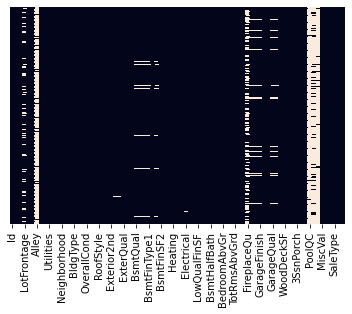

In [62]:
sns.heatmap(train.isnull(),yticklabels= False,cbar=False)

**Calculating Correlation**

In [63]:
#Calculating correlation of each attributes with target variable 'SalePrice'
correlation = train.corr()
print(correlation['SalePrice'].sort_values(ascending =  False),'\n')

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

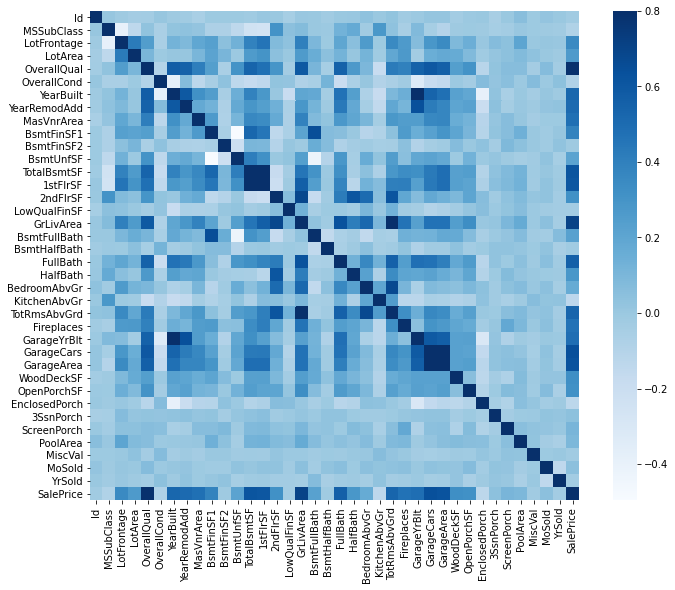

In [64]:
#Plotting correlation heatmap.
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,cmap= 'Blues',vmax=.8, square=True);

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


<AxesSubplot:>

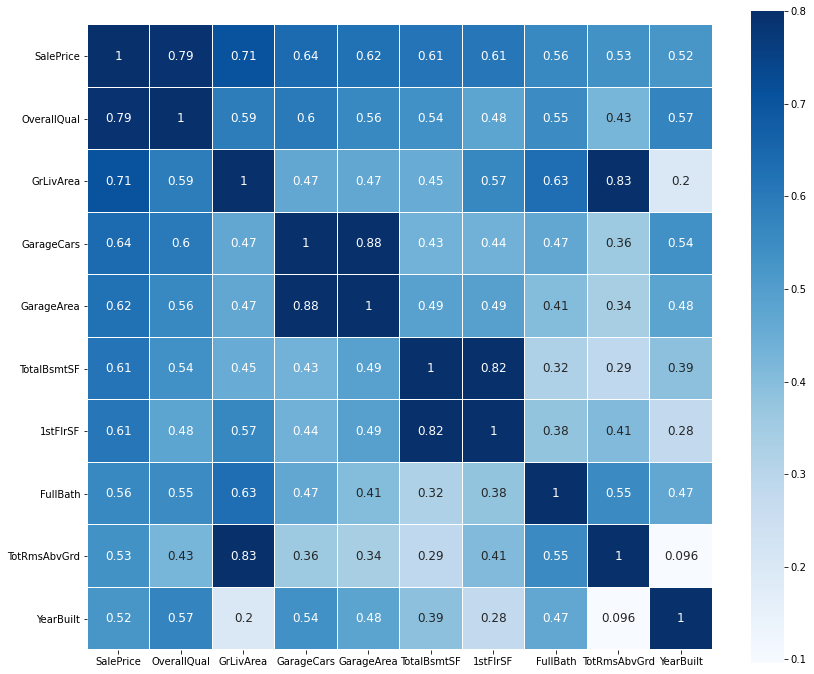

In [84]:
#Plotting 10 highly correlated attributes with 'SalePrice'.
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm,vmax=0.8,linewidth=0.01,square = True, annot = True,cmap='Blues',linecolor = 'white',xticklabels=cols.values,annot_kws={'size':12},yticklabels =cols.values)


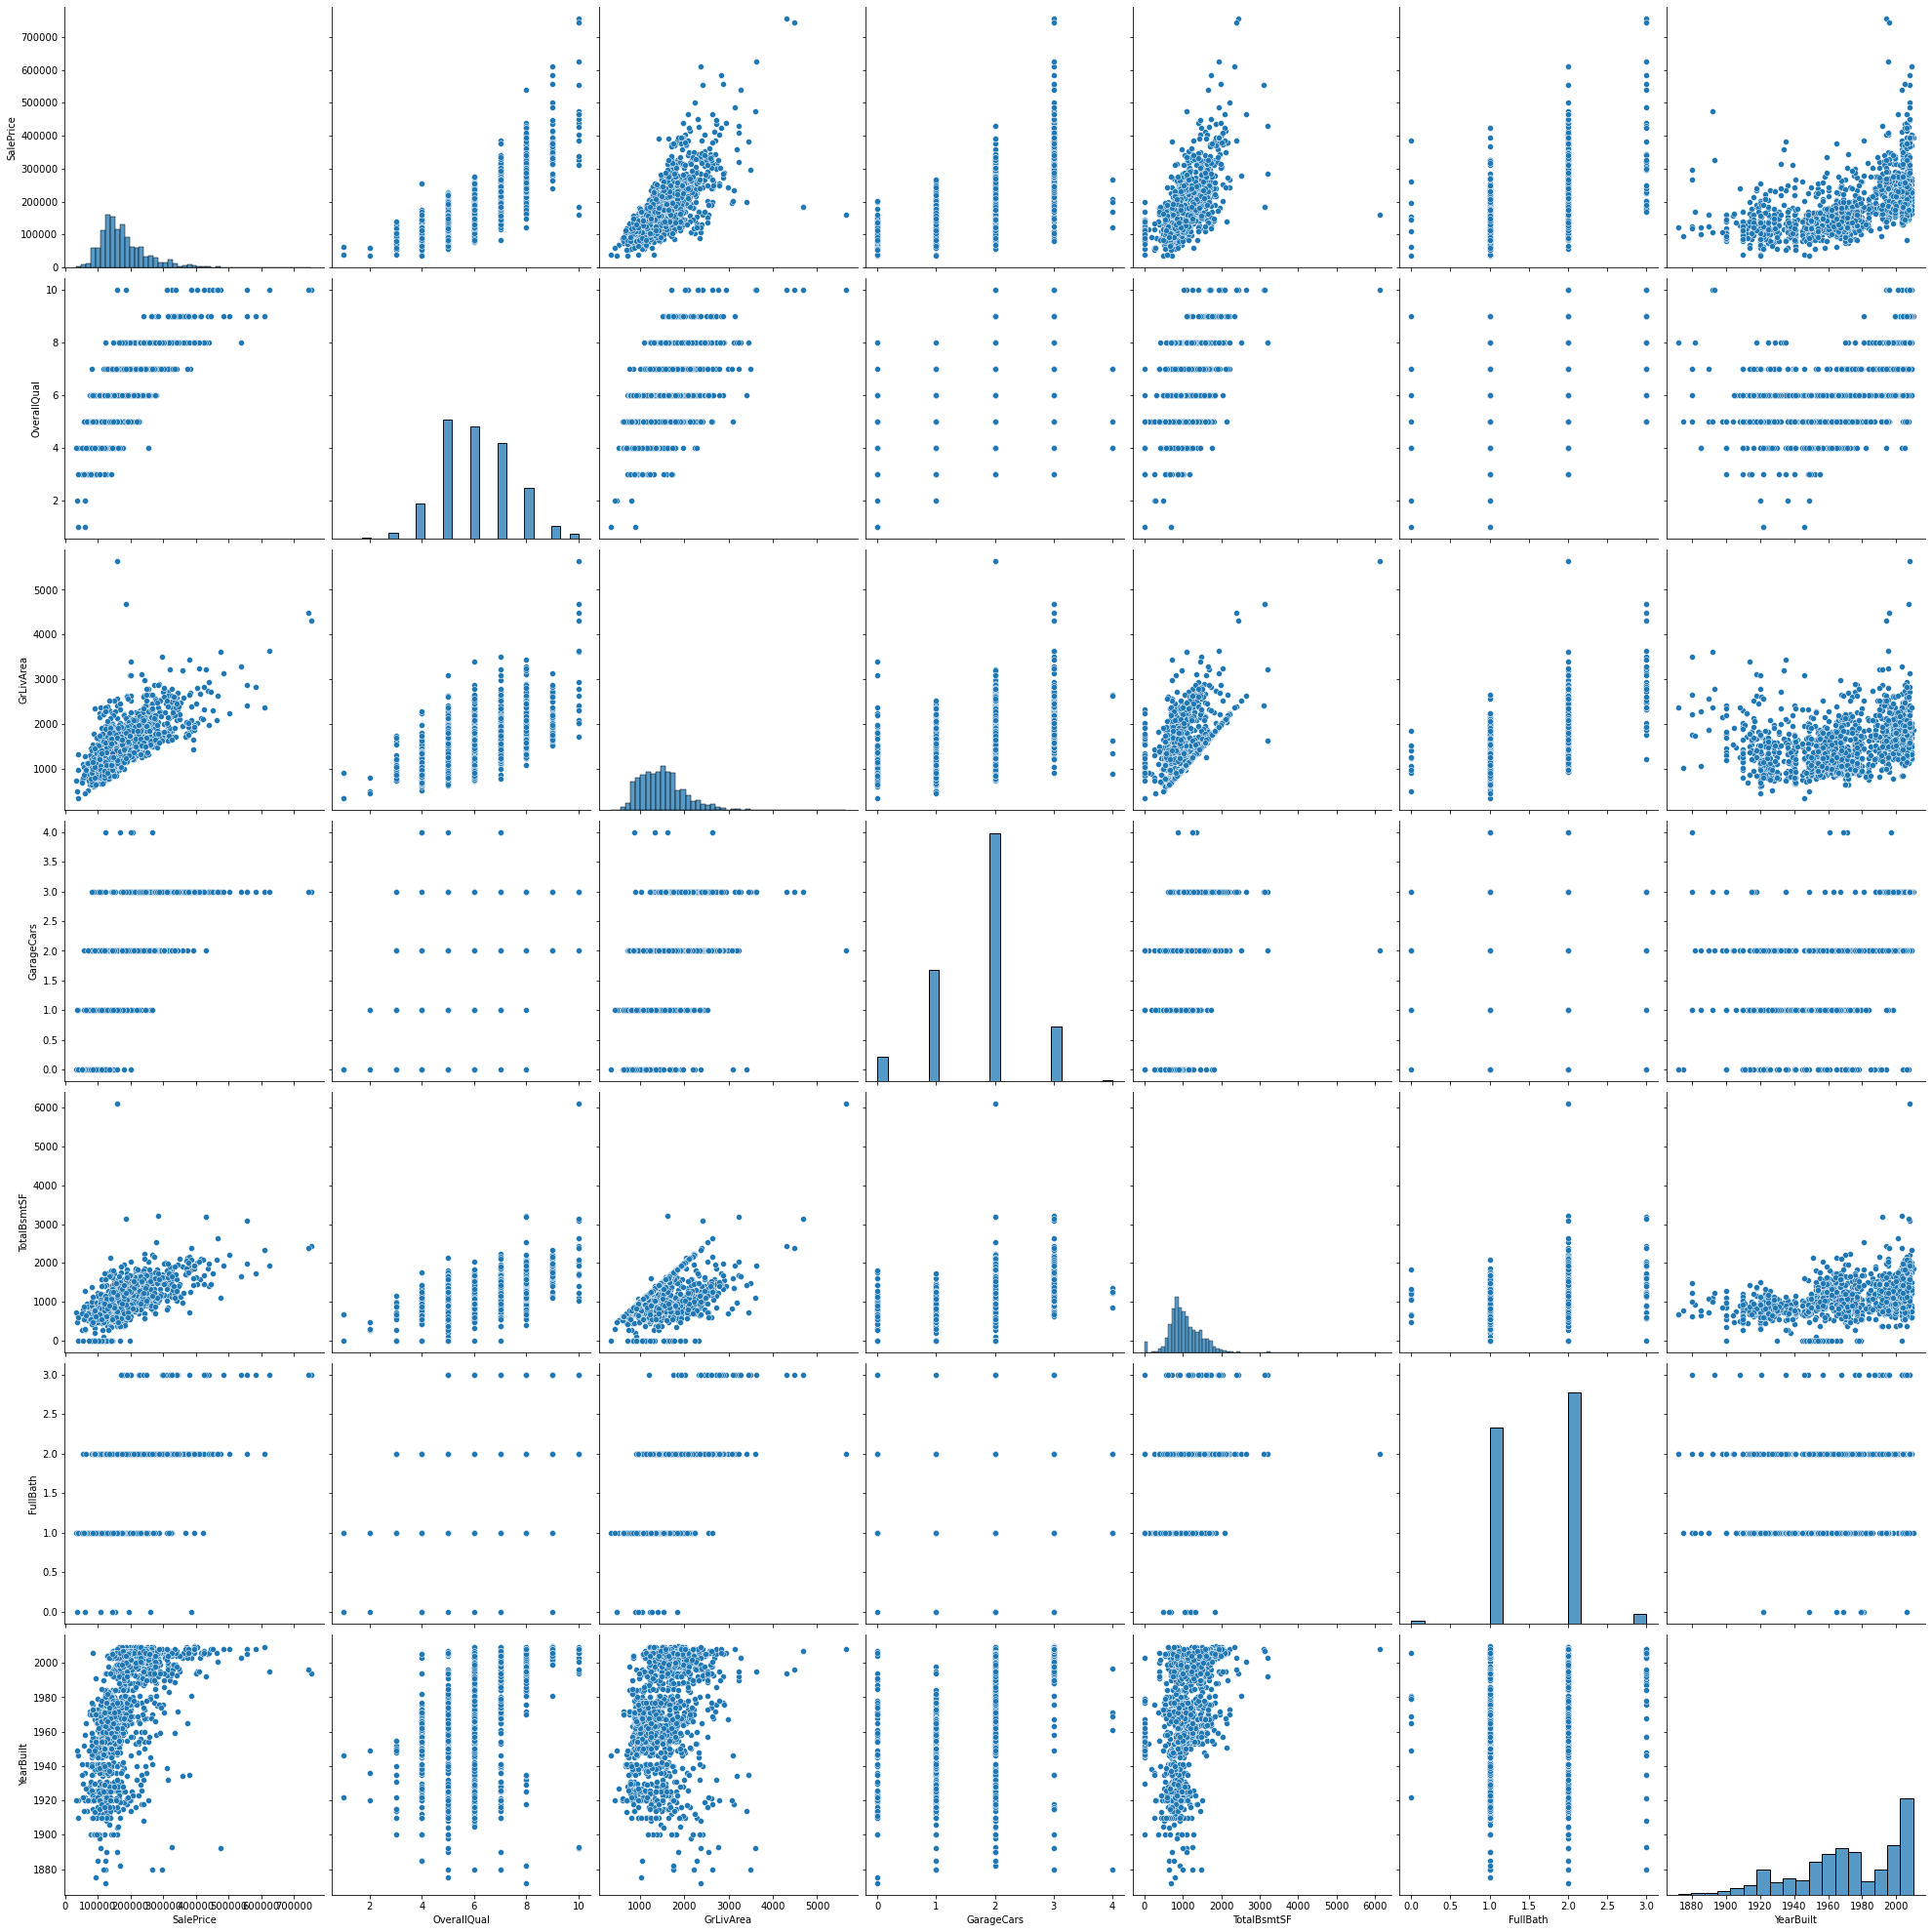

In [65]:
#Plotting scatter plot.
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 4)
plt.show();

<AxesSubplot:xlabel='SalePrice'>

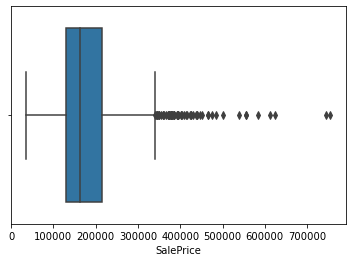

In [67]:
#Box plot of 'SalePrice'
sns.boxplot(x=train['SalePrice'])

**Merging train and test data for cleaning and transformations**

In [69]:
#Concatenate train and test data to obtain data DataFrame.
target = train['SalePrice']
ids = test['Id']

train = train.drop(['Id','SalePrice'],axis = 1)
test =  test.drop('Id',axis =1 )

data = pd.concat([train, test], axis =0 ).reset_index(drop = True)
data.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

**Feature Selection**
*  Attributes with low correlation with target variable 'SalePrice' are removed. *
*  Removal of multicollinear attributes. *
*  Attributes with more than 50 % of missing values are removed. *

In [70]:
remove_columns =['GarageArea','TotalBsmtSF','TotRmsAbvGrd','GrLivArea','FireplaceQu','Fence','Alley','MiscFeature','PoolQC','BedroomAbvGr','ScreenPorch','PoolArea','MoSold','3SsnPorch','BsmtHalfBath','MiscVal','LowQualFinSF','YrSold','OverallCond','MSSubClass','EnclosedPorch','KitchenAbvGr']

In [71]:
data.drop(remove_columns,axis=1,inplace=True)

In [72]:
data.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenQual', 'Functional',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [75]:
#filling the values of missing categorical features
data.select_dtypes(object).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [76]:
#Filling missing values in which NA specifies to actual category value.
for column in ['BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish','GarageQual','GarageCond']:
    data[column] = data[column].fillna('None')
#filling missing values in which there is actual missing value with mode value.
for column in ['MSZoning','Utilities','Exterior1st', 'Exterior2nd', 'MasVnrType','Electrical','KitchenQual','Functional','SaleType']:
    data[column] = data[column].fillna(data[column].mode()[0])

In [77]:
#checking whether the categorical attributes have missing value or not.
data.select_dtypes('object').isna().sum()

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
dtype: int64

In [87]:
#filling numeral missing values with mean of respective columns.
for column in ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'BsmtFullBath', 'GarageYrBlt',
       'GarageCars']:
    data[column] = data[column].fillna(data[column].mean())


In [88]:
#finding attributes with high skewness
skew = pd.DataFrame(data.select_dtypes(np.number).columns, columns=['Feature'])
skew['Skew'] = skew['Feature'].apply(lambda feature: scipy.stats.skew(data[feature]))
skew['Absolute_Skew'] = skew['Skew'].apply(abs)
skew['is_Skew'] = skew['Absolute_Skew'].apply(lambda x: True if x >= 0.5 else False)
skew


,Feature,Skew,Absolute_Skew,is_Skew
0,LotFrontage,-1.019461,1.019461,True
1,LotArea,-0.504751,0.504751,True
2,OverallQual,0.197110,0.197110,False
3,YearBuilt,-0.626215,0.626215,True
4,YearRemodAdd,-0.451020,0.451020,False
5,MasVnrArea,0.504573,0.504573,True
6,BsmtFinSF1,-0.618185,0.618185,True
7,BsmtFinSF2,2.458515,2.458515,True
8,BsmtUnfSF,-2.159207,2.159207,True
9,1stFlrSF,0.064828,0.064828,False


In [90]:
#log transformation of skewed data
for column in skew.query("is_Skew == True")['Feature'].values:
    data[column] = np.log1p(data[column])


In [83]:
#encoding of categorical data
data = pd.get_dummies(data)
data

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,7.602900,2003,5.283204,6.561031,0.0,5.017280,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,6,7.589336,1976,0.000000,6.886532,0.0,5.652489,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,7,7.601902,2002,5.093750,6.188264,0.0,6.075346,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,7,7.557995,1970,0.000000,5.379897,0.0,6.293419,6.869014,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,8,7.601402,2000,5.860786,6.486161,0.0,6.196444,7.044033,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,3.091042,7.568896,4,7.586296,1970,0.000000,0.000000,0.0,6.304449,6.304449,...,0,0,0,1,0,0,0,0,1,0
2915,3.091042,7.546974,4,7.586296,1970,0.000000,5.533389,0.0,5.686975,6.304449,...,0,0,0,1,1,0,0,0,0,0
2916,5.081404,9.903538,5,7.581210,1996,0.000000,7.110696,0.0,0.000000,7.110696,...,0,0,0,1,1,0,0,0,0,0
2917,4.143135,9.253591,5,7.597396,1992,0.000000,5.823046,0.0,6.356108,6.878326,...,0,0,0,1,0,0,0,0,1,0


In [84]:
#Scaling
scaler= StandardScaler()
scaler.fit(data)

data =pd.DataFrame(scaler.transform(data), index = data.index, columns = data.columns)
data

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.049717,-0.103719,0.646183,1.040634,0.896833,1.207310,0.783085,-0.363104,-0.326929,-0.777287,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.588360,0.146544,-0.063185,0.161526,-0.395604,-0.806456,0.892295,-0.363104,0.013451,0.424865,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.088781,0.457629,0.646183,0.975922,0.848965,1.135097,0.658017,-0.363104,0.240041,-0.554028,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295173,0.136301,0.646183,-1.869638,-0.682812,-0.806456,0.386799,-0.363104,0.356896,-0.419015,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.738543,0.922662,1.355551,0.943542,0.753229,1.427464,0.757965,-0.363104,0.304932,0.123520,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.472654,-2.993401,-1.481920,-0.035461,-0.682812,-0.806456,-1.418231,-0.363104,0.362806,-2.169094,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.472654,-3.036401,-1.481920,-0.035461,-0.682812,-0.806456,0.438297,-0.363104,0.031931,-2.169094,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.728701,1.586172,-0.772552,-0.365110,0.561757,-0.806456,0.967505,-0.363104,-3.015461,0.330167,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.194659,0.311255,-0.772552,0.683917,0.370284,-0.806456,0.535481,-0.363104,0.390488,-0.390149,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


<AxesSubplot:>

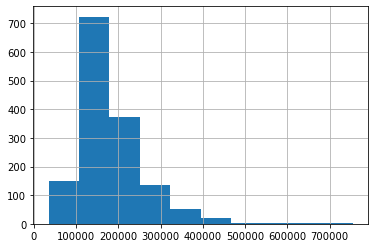

In [82]:
target.hist()

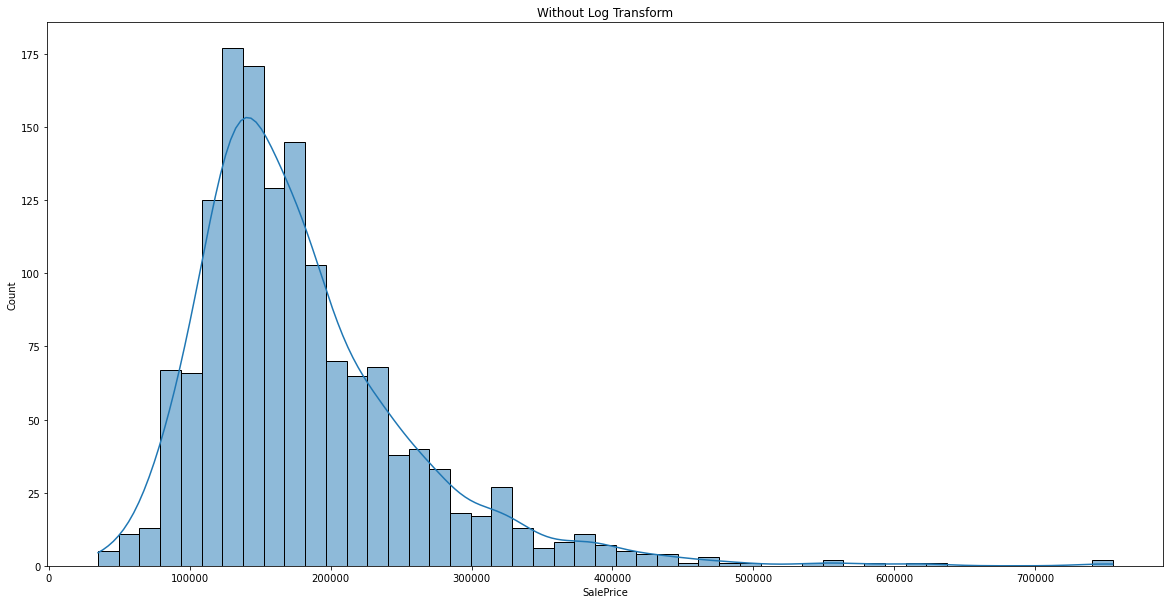

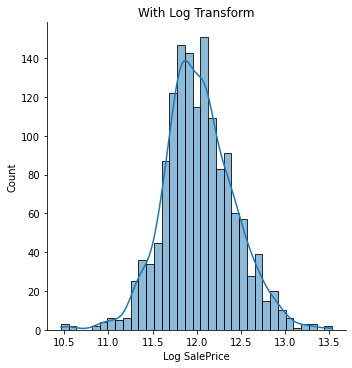

In [83]:
#visualization of log transformation of target variable
plt.figure(figsize=(20, 10))
sns.histplot(target, kde=True)
plt.title("Without Log Transform")
sns.displot(np.log1p(target), kde=True)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

In [84]:
#Splitting train and test
train = data.loc[:train.index.max(),:]
test = data.loc[train.index.max()+1:,:]

In [85]:
#log transformation of target variable
log_target = np.log1p(target)

**Model Selection**

In [92]:
#define function for calculating metrics R squared score and RMSE score.
def rsqr_score(test, pred):
    r_sqr = r2_score(test, pred)
    return r_sqr

def rmse_score(test, pred):
    rmse = np.sqrt(mean_squared_error(test, pred))
    return rmse

def print_score(test, pred, model):
    print(f"- Regression: {model}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")
    


In [87]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(train,log_target , test_size = 0.2, random_state = 42)

In [88]:
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(1168, 262)
y_train:(1168,)

X_test:(292, 262)
y_test:(292,)


**Ridge Regression**

In [93]:
ridge_model = Ridge(alpha = 0.001)
scores_ridge = -1 * cross_val_score(ridge_model, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

print("MSE scores:\n", scores_ridge)
print("Mean MSE scores:", scores_ridge.mean())

MSE scores:
 [0.02034559 0.02705259 0.02892104 0.0309175  0.01309099]
Mean MSE scores: 0.024065540258292422


In [94]:
ridge_model.fit(X_train, y_train)
y_pred_r = ridge_model.predict(X_test)
print_score(y_test, y_pred_r, "Ridge")

- Regression: Ridge
R²: 0.9110803427886773
RMSE: 0.12881531406320715



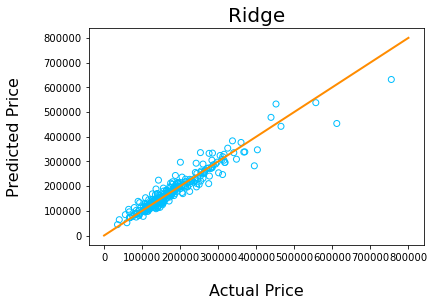

In [95]:
plt.figure()
plt.title("Ridge", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_r),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

**Lassso Regression**

In [47]:
lasso_model = Lasso(alpha = 0.001)

In [96]:
scores_lasso = -1 * cross_val_score(lasso_model, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

print("MSE scores:\n", scores_lasso)
print("Mean MSE scores:", scores_lasso.mean())

MSE scores:
 [0.017034   0.02352818 0.0271798  0.02650278 0.01258769]
Mean MSE scores: 0.021366490982592544


In [97]:
lasso_model.fit(X_train, y_train)
y_pred_l = lasso_model.predict(X_test)
print_score(y_test, y_pred_l, "Lasso")

- Regression: Lasso
R²: 0.9131958852254296
RMSE: 0.1272737273425993



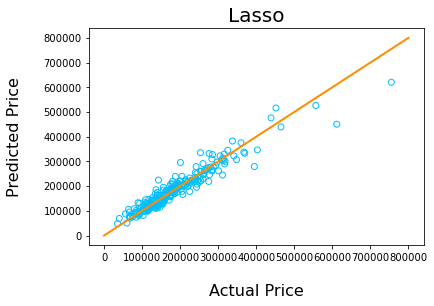

In [98]:
plt.figure()
plt.title("Lasso", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_l),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

**Random Forest Regression**

In [99]:
ran_model = RandomForestRegressor()

In [100]:
scores_ran = -1 * cross_val_score(ran_model, X_train, y_train,
                                  cv=5,
                                  scoring='neg_mean_squared_error')

print("MSE scores:\n", scores_ran)
print("Mean MSE scores:", scores_ran.mean())

MSE scores:
 [0.02086314 0.02695664 0.03253487 0.02076698 0.01774732]
Mean MSE scores: 0.02377379070358784


In [101]:
ran_model.fit(X_train, y_train)
y_pred_ran = ran_model.predict(X_test)
print_score(y_test, y_pred_ran, "Random Forest")

- Regression: Random Forest
R²: 0.8726806273181051
RMSE: 0.15414017647162495



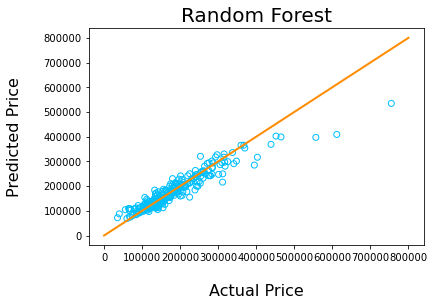

In [103]:
plt.figure()
plt.title("Random Forest", fontsize=20)
plt.scatter(np.exp(y_test), np.exp(y_pred_ran),
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

**Prediction on test data**

In [104]:
#predicting on a test data
y_pred = np.exp(lasso_model.predict(test))

output = pd.DataFrame({"Id": ids,
                       "SalePrice": y_pred})

output.to_csv("Prediction.csv")
output

,Id,SalePrice
0,1461,119496.708233
1,1462,157556.839754
2,1463,184714.369087
3,1464,192670.506553
4,1465,206687.745121
5,1466,167290.472671
6,1467,174843.321983
7,1468,163495.570774
8,1469,199365.288809
9,1470,121716.199032
